In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import matplotlib.pyplot as plt

2025-12-13 16:06:06.355219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765641966.618238      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765641966.689969      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_df1 = pd.read_csv("/kaggle/input/cyberbullying-tweets-dataset/cyber_bullying_data/test_data.csv")

test_df1 = pd.read_csv("/kaggle/input/cyberbullying-tweets-dataset/cyber_bullying_data/test_data.csv")


In [3]:
test_df = test_df1[test_df1['cyberbullying_type'] != 'not_cyberbullying']
train_df = train_df1[train_df1['cyberbullying_type'] != 'not_cyberbullying']

In [4]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download stopwords if not already downloaded
nltk.download('stopwords')

def preprocess_text(text):
    """Cleans text by lowercasing, removing stopwords, and applying stemming."""
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove non-alphabetic characters (keep spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize and remove stopwords, apply stemming
    words = text.split()
    words = [ps.stem(word) for word in words if word not in stop_words]
    
    # Join words back into a string
    return " ".join(words)

train_df = train_df.copy()
test_df = test_df.copy()

# ✅ Use .loc to assign new column safely
train_df.loc[:, 'cleaned_text'] = train_df['tweet_text'].apply(preprocess_text)
test_df.loc[:, 'cleaned_text'] = test_df['tweet_text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
label_mapping = {
    "other_cyberbullying": 0,
    "religion": 1,
    "age": 2,
    "gender": 3,
    "ethnicity": 4
}

# Apply mapping
train_df["cyberbullying_encoded_type"] = train_df["cyberbullying_type"].map(label_mapping)
test_df["cyberbullying_encoded_type"] = test_df["cyberbullying_type"].map(label_mapping)

In [6]:
X_train, X_val, y_train, y_val = train_df['cleaned_text'],test_df['cleaned_text'],train_df['cyberbullying_encoded_type'],test_df['cyberbullying_encoded_type']
#X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

In [7]:
max_len = 35    
oov_token = '00_V' 
padding_type = 'post'
trunc_type = 'post'  

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  15888


In [8]:
train_sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(val_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

#test_sequences = tokenizer.texts_to_sequences(X_test)
#X_test = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [9]:
from tensorflow.keras import layers, Sequential
import tensorflow as tf

# ------------------------------
# Transformer Encoder Layer
# ------------------------------
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons, dropout_rate=0.3):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.heads = heads
        self.neurons = neurons
        self.dropout_rate = dropout_rate

        # Multi-head self-attention
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)

        # Feed-forward network
        self.ffn = Sequential([
            layers.Dense(neurons, activation="relu"),
            layers.Dropout(dropout_rate),
            layers.Dense(embed_dim),
        ])

        # Normalization and dropout
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=None):
        # Self-attention + residual
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # Feed-forward + residual
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


# ------------------------------
# Token + Position Embedding Layer
# ------------------------------
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [10]:
from tensorflow.keras.layers import Dropout


In [11]:
from tensorflow.keras import regularizers
from tensorflow.keras import layers, regularizers, Model, Sequential
import tensorflow as tf

In [12]:
# Hyperparams
embed_dim = 50  
heads = 2  
neurons = 16   # smaller feed-forward size (less complexity)
maxlen = 35
vocab_size = 46911

# Model definition
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x)
# ⚡ Output for binary classification
outputs = layers.Dense(
    5, activation="softmax",  # single neuron with sigmoid
    kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6)
)(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile for binary classification
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)

model.summary()

2025-12-13 16:06:30.955100: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 35, 50)         │     2,347,300 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 35, 50)         │        22,216 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,369,771 (9.04 MB)

 Trainable params: 2,369,771 (9.04 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [14]:
checkpoint = ModelCheckpoint(
    "Transformarf_binary_model.h5",   
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

earlystopping = EarlyStopping(
    monitor="val_loss",
    patience=3,   
    restore_best_weights=True,
    verbose=1
)

lr_reduction = ReduceLROnPlateau(
    monitor="val_loss",
    patience=2,
    factor=0.5,   
    min_lr=1e-7,
    verbose=1
)


In [15]:
history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=25,
                    batch_size=32,
                    callbacks=[checkpoint, earlystopping, lr_reduction])

Epoch 1/25
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2882 - loss: 1.6060
Epoch 1: val_loss improved from inf to 1.13091, saving model to Transformarf_binary_model.h5
248/248 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.2890 - loss: 1.6048 - val_accuracy: 0.7176 - val_loss: 1.1309 - learning_rate: 1.0000e-04
Epoch 2/25
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6863 - loss: 1.0841
Epoch 2: val_loss improved from 1.13091 to 0.60690, saving model to Transformarf_binary_model.h5
248/248 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.6867 - loss: 1.0832 - val_accuracy: 0.8538 - val_loss: 0.6069 - learning_rate: 1.0000e-04
Epoch 3/25
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8572 - loss: 0.5900
Epoch 3: val_loss improved from 0.60690 to 0.31530, saving model to Transformarf_binary_model.h5
248/248 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.8573 - loss: 0.5896 - val_accuracy: 0.8979 - val_loss: 0.3153 - learning_rate: 1.0000e-04
Epoch 4/25
24

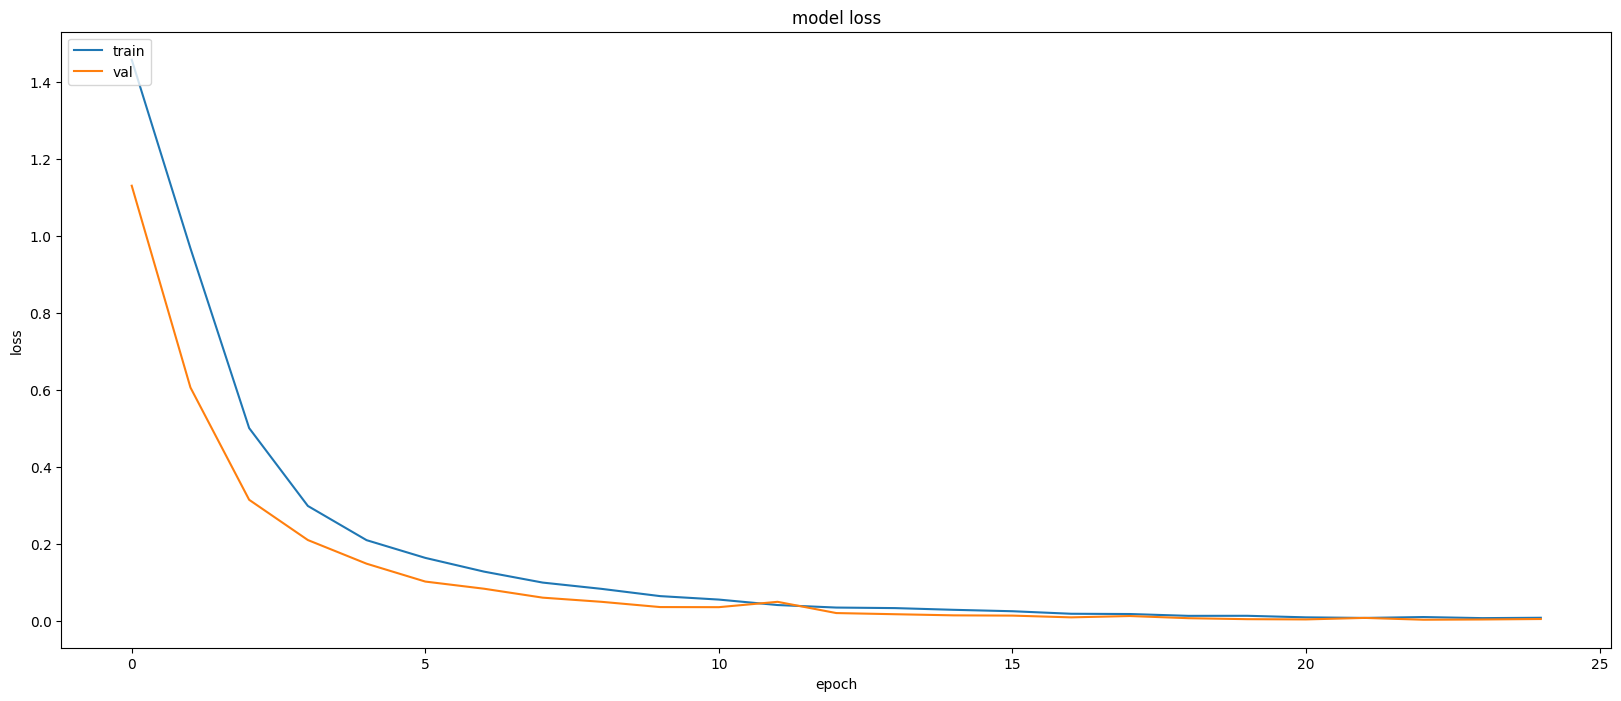

In [16]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

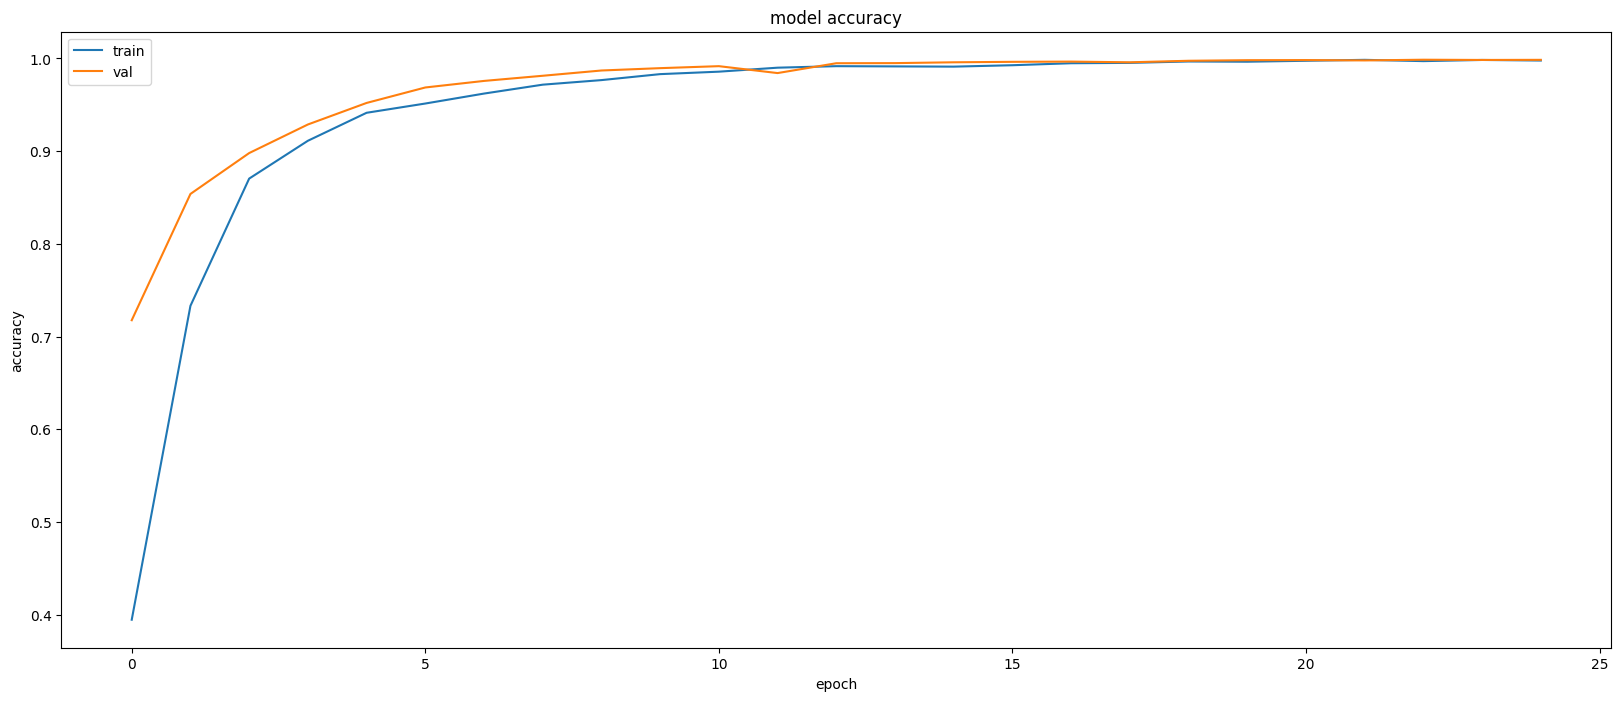

In [17]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Classification Report:

                     precision    recall  f1-score   support

other_cyberbullying       1.00      1.00      1.00      1612
           religion       1.00      1.00      1.00      1566
                age       1.00      1.00      1.00      1603
             gender       0.99      1.00      1.00      1531
          ethnicity       1.00      1.00      1.00      1603

           accuracy                           1.00      7915
          macro avg       1.00      1.00      1.00      7915
       weighted avg       1.00      1.00      1.00      7915



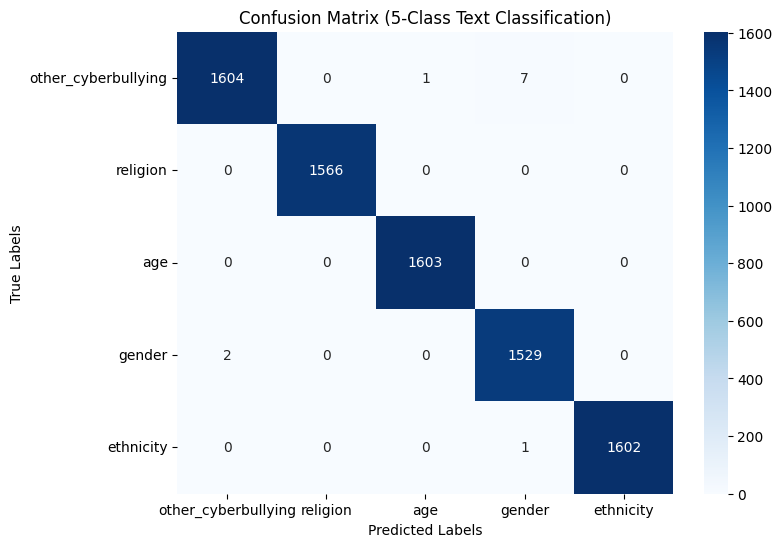

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Predict
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class names (for reports)
class_names = ['other_cyberbullying', 'religion', 'age', 'gender', 'ethnicity']

# Classification report
print("Classification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (5-Class Text Classification)')
plt.show()
